# SageMaker Debugger 

## Introduction <a id='intro'></a>

Amazon SageMaker Debugger is a NEW capability of Amazon SageMaker that allows debugging machine learning training. The capability helps you monitor the training jobs in near real time using rules and alert you once it has detected inconsistency in training. 

Using Amazon SageMaker Debugger is a two step process: Saving tensors and Analysis.
Let's look at each one of them closely.

### Saving tensors

In deep learning algorithms, tensors define the state of the training job at any particular instant in its lifecycle.  Amazon SageMaker Debugger exposes a library which allows you to capture these tensors and save them for analysis.

Although XGBoost is not a deep learning algorithm, Amazon SageMaker Debugger is highly customizable and can help provide interpretability by saving insightful metrics, such as performance metrics or feature importances, at different frequencies.
Refer to [documentation](https://github.com/awslabs/sagemaker-debugger/blob/master/docs/xgboost.md) for details on how to save the metrics you want.

Metrics saved can also include feature importance and SHAP values for all features in the dataset. The feature importance and SHAP values collected are what we will use to provide local and global explainability.


### Analysis

After the tensors are saved, perform automatic analysis by running debugging ***Rules***.
On a very broad level, a rule is Python code used to detect certain conditions during training.
Some of the conditions that a data scientist training an algorithm may care about are monitoring for gradients getting too large or too small, detecting overfitting, and so on.
Amazon SageMaker Debugger comes pre-packaged with certain rules that can be invoked on Amazon SageMaker. Users can also write their own rules using the Amazon SageMaker Debugger APIs. 
For more information about automatic analysis using a rule, see the [rules documentation](https://github.com/awslabs/sagemaker-debugger/blob/master/docs/analysis.md).

#### Prerequisites

In [1]:
!python -m pip install smdebug
!conda install -c conda-forge -y shap

#### 1. Imports 

In [2]:
from sagemaker.debugger import rule_configs, Rule, DebuggerHookConfig, CollectionConfig
from sagemaker.inputs import TrainingInput
from sagemaker.estimator import Estimator
from sagemaker import get_execution_role
from smdebug.trials import create_trial
import matplotlib.pyplot as plt
from itertools import islice
import pandas as pd
import numpy as np
import sagemaker
import logging
import boto3
import time
import shap
import os
import re

[2020-12-09 23:04:35.933 ip-172-16-75-100:31201 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None


In [3]:
logger = logging.getLogger('sagemaker')
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler())

In [4]:
logger.info('[Using SageMaker version: {}]'.format(sagemaker.__version__))

[Using SageMaker version: 2.16.4.dev0]


#### 2. Essentials

In [5]:
region = boto3.Session().region_name
role = get_execution_role()

BUCKET = 'sagemaker-demo-892313895307' # USE YOUR ACCOUNT ID OR INITIALS AS SUFFIX
PREFIX = 'xgboost-clf'

##### 2.1 Get XGBoost Container Image

In [6]:
container_uri = sagemaker.image_uris.retrieve(region=region, 
                                              framework='xgboost', 
                                              version='1.0-1', 
                                              image_scope='training',
                                              py_version='py3')

Defaulting to only supported image scope: cpu.


##### 2.2 Load Data and S3 Locations

In [7]:
feature_names = ['bmi', 'diastolic_bp_change', 'systolic_bp_change', 'respiratory_rate']
X_train = pd.read_csv('.././DATA/train/train.csv', names=feature_names)

In [8]:
X_train.head()

,bmi,diastolic_bp_change,systolic_bp_change,respiratory_rate
0,-1.483765,-1.003436,-0.927406,-0.817379
1,0.947850,-1.003436,-0.927406,-0.662177
0,-1.034765,2.206180,2.057467,-0.817379
0,-1.406122,0.179054,-0.445975,-0.817379
0,0.366195,-0.665582,0.228029,-0.431359


In [9]:
train_set_location = 's3://{}/{}/train/'.format(BUCKET, PREFIX)
test_set_location = 's3://{}/{}/test/'.format(BUCKET, PREFIX)

In [10]:
train_set_pointer = TrainingInput(s3_data=train_set_location, content_type='csv')
test_set_pointer = TrainingInput(s3_data=test_set_location, content_type='csv')

### 3.  Enabling Debugger in Estimator object

#### DebuggerHookConfig

Enabling Amazon SageMaker Debugger in training job can be accomplished by adding its configuration into Estimator object constructor:

```python
from sagemaker.debugger import DebuggerHookConfig, CollectionConfig

estimator = Estimator(
    ...,
    debugger_hook_config = DebuggerHookConfig(
        s3_output_path="s3://{bucket_name}/{location_in_bucket}",  # Required
        collection_configs=[
            CollectionConfig(
                name="metrics",
                parameters={
                    "save_interval": "10"
                }
            )
        ]
    )
)
```
Here, the `DebuggerHookConfig` object instructs `Estimator` what data we are interested in.
Two parameters are provided in the example:

- `s3_output_path`: it points to S3 bucket/path where we intend to store our debugging tensors.
  Amount of data saved depends on multiple factors, major ones are: training job / data set / model / frequency of saving tensors.
  This bucket should be in your AWS account, and you should have full access control over it. <br><br>
  **Important Note**: this s3 bucket should be originally created in the same region where your training job will be running, otherwise you might run into problems with cross region access.

- `collection_configs`: it enumerates named collections of tensors we want to save.
  Collections are a convinient way to organize relevant tensors under same umbrella to make it easy to navigate them during analysis.
  In this particular example, you are instructing Amazon SageMaker Debugger that you are interested in a single collection named `metrics`.
  We also instructed Amazon SageMaker Debugger to save metrics every 10 iteration.
  See [Collection](https://github.com/awslabs/sagemaker-debugger/blob/master/docs/api.md#collection) documentation for all parameters that are supported by Collections and DebuggerConfig documentation for more details about all parameters DebuggerConfig supports.
  
#### Rules

Enabling Rules in training job can be accomplished by adding the `rules` configuration into Estimator object constructor.

- `rules`: This new parameter will accept a list of rules you wish to evaluate against the tensors output by this training job.
  For rules, Amazon SageMaker Debugger supports two types:
  - SageMaker Rules: These are rules specially curated by the data science and engineering teams in Amazon SageMaker which you can opt to evaluate against your training job.
  - Custom Rules: You can optionally choose to write your own rule as a Python source file and have it evaluated against your training job.
    To provide Amazon SageMaker Debugger to evaluate this rule, you would have to provide the S3 location of the rule source and the evaluator image.

In this example, you will use a Amazon SageMaker's LossNotDecreasing rule, which helps you identify if you are running into a situation where the training loss is not going down.

```python
from sagemaker.debugger import rule_configs, Rule

estimator = Estimator(
    ...,
    rules=[
        Rule.sagemaker(
            rule_configs.loss_not_decreasing(),
            rule_parameters={
                "collection_names": "metrics",
                "num_steps": "10",
            },
        ),
    ],
)
```

- `rule_parameters`: In this parameter, you provide the runtime values of the parameter in your constructor.
  You can still choose to pass in other values which may be necessary for your rule to be evaluated.
  In this example, you will use Amazon SageMaker's LossNotDecreasing rule to monitor the `metircs` collection.
  The rule will alert you if the tensors in `metrics` has not decreased for more than 10 steps.

#### 3.1 Create Debugger Hook Configuration

In [11]:
s3_output_path = f's3://{BUCKET}/{PREFIX}/debug'
base_job_name = 'classifier-debug'
save_interval = 5
hyperparameters = {
    'objective': 'binary:logistic',
    'num_round': 100,
    'eta': 0.8,
    'max_depth': 3,
    'min_child_weight': 4
}

In [12]:
debugger_hook_config = DebuggerHookConfig(
        s3_output_path=s3_output_path,  # required
        collection_configs=[
            CollectionConfig(
                name='metrics',
                parameters={
                    'save_interval': str(save_interval)
                }
            ),
            CollectionConfig(
                name='feature_importance',
                parameters={
                    'save_interval': str(save_interval)
                }
            ),
            CollectionConfig(
                name='full_shap',
                parameters={
                    'save_interval': str(save_interval)
                }
            ),
            CollectionConfig(
                name='average_shap',
                parameters={
                    'save_interval': str(save_interval)
                }
            ),
        ],
    )

#### 3.2 Create Debugger Rules 

In [13]:
rules = [Rule.sagemaker(rule_configs.loss_not_decreasing(),
                        rule_parameters={'collection_names': 'metrics', 
                                         'num_steps': str(save_interval * 2)})]

#### 3.3 Create Estimator

Now train an XGBoost model with Amazon SageMaker Debugger enabled and monitor the training jobs. This is done using the Amazon SageMaker Estimator API. While the training job is running, use Amazon SageMaker Debugger API to access saved tensors in <b>real time</b> and visualize them. <br>
<b>Note:</b>You can rely on Amazon SageMaker Debugger to take care of downloading a fresh set of tensors every time you query for them.

In [14]:
xgboost_estimator = Estimator(role=role, 
                              base_job_name=base_job_name, 
                              instance_count=1, 
                              instance_type='ml.m5.xlarge', 
                              image_name=container_uri, 
                              hyperparameters=hyperparameters, 
                              max_run=1800,
                              image_uri=container_uri,
                              debugger_hook_config=debugger_hook_config,
                              rules=rules)

This is a fire and forget event. By setting wait=False, you submit the job to run in the background.
Amazon SageMaker starts one training job and release control to next cells in the notebook.
Follow this notebook to see status of the training job.

In [15]:
xgboost_estimator.fit(
    {'train': train_set_pointer, 
     'validation': test_set_pointer},
     wait=False
)

Defaulting to the only supported framework/algorithm version: latest.
Ignoring unnecessary instance type: None.
Defaulting to the only supported framework/algorithm version: latest.
Ignoring unnecessary instance type: None.
Creating training-job with name: classifier-debug-2020-12-09-23-12-15-813


As a result of the above command, Amazon SageMaker starts one training job and one rule job for you. The first one is the job that produces the tensors to be analyzed. The second one analyzes the tensors to check if train-error and validation-error are not decreasing at any point during training.

Check the status of the training job below. After your training job is started, Amazon SageMaker starts a rule-execution job to run the LossNotDecreasing rule.

The cell below will block till the training job is complete.

In [16]:
while True:
    job_name = xgboost_estimator.latest_training_job.name
    client = xgboost_estimator.sagemaker_session.sagemaker_client
    description = client.describe_training_job(TrainingJobName=job_name)
    training_job_status = description['TrainingJobStatus']
    rule_job_summary = xgboost_estimator.latest_training_job.rule_job_summary()
    rule_evaluation_status = rule_job_summary[0]['RuleEvaluationStatus']
    print('Training Job Status: {}, Rule Evaluation Status: {}'.format(training_job_status, rule_evaluation_status))
    
    if training_job_status in ['Completed', 'Failed']:
        break

    time.sleep(10)

InProgress
Training Job Status: InProgress, Rule Evaluation Status: InProgress
InProgress
Training Job Status: InProgress, Rule Evaluation Status: InProgress
InProgress
Training Job Status: InProgress, Rule Evaluation Status: InProgress
InProgress
Training Job Status: InProgress, Rule Evaluation Status: InProgress
InProgress
Training Job Status: InProgress, Rule Evaluation Status: InProgress
InProgress
Training Job Status: InProgress, Rule Evaluation Status: InProgress
InProgress
Training Job Status: InProgress, Rule Evaluation Status: InProgress
InProgress
Training Job Status: InProgress, Rule Evaluation Status: InProgress
InProgress
Training Job Status: InProgress, Rule Evaluation Status: InProgress
InProgress
Training Job Status: InProgress, Rule Evaluation Status: InProgress
InProgress
Training Job Status: InProgress, Rule Evaluation Status: InProgress
InProgress
Training Job Status: InProgress, Rule Evaluation Status: InProgress
InProgress
Training Job Status: InProgress, Rule Eva

### Evaluate Results 

In [17]:
xgboost_estimator.latest_training_job.rule_job_summary()

[{'RuleConfigurationName': 'LossNotDecreasing',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:892313895307:processing-job/classifier-debug-2020-12-0-lossnotdecreasing-39086f2a',
  'RuleEvaluationStatus': 'NoIssuesFound',
  'LastModifiedTime': datetime.datetime(2020, 12, 9, 23, 19, 26, 342000, tzinfo=tzlocal())},
 {'RuleConfigurationName': 'ProfilerReport-1607555536',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:892313895307:processing-job/classifier-debug-2020-12-0-profilerreport-1607555536-943ca4d0',
  'RuleEvaluationStatus': 'NoIssuesFound',
  'LastModifiedTime': datetime.datetime(2020, 12, 9, 23, 16, 23, 442000, tzinfo=tzlocal())}]

In [18]:
s3_output_path = xgboost_estimator.latest_job_debugger_artifacts_path()
trial = create_trial(s3_output_path)

[2020-12-09 23:20:50.820 ip-172-16-75-100:31201 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-demo-892313895307/xgboost-clf/debug/classifier-debug-2020-12-09-23-12-15-813/debug-output


In [19]:
trial.tensor_names()

[2020-12-09 23:20:52.751 ip-172-16-75-100:31201 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2020-12-09 23:20:53.773 ip-172-16-75-100:31201 INFO trial.py:210] Loaded all steps


['average_shap/f0',
 'average_shap/f1',
 'average_shap/f2',
 'average_shap/f3',
 'feature_importance/cover/f0',
 'feature_importance/cover/f1',
 'feature_importance/cover/f2',
 'feature_importance/cover/f3',
 'feature_importance/gain/f0',
 'feature_importance/gain/f1',
 'feature_importance/gain/f2',
 'feature_importance/gain/f3',
 'feature_importance/total_cover/f0',
 'feature_importance/total_cover/f1',
 'feature_importance/total_cover/f2',
 'feature_importance/total_cover/f3',
 'feature_importance/total_gain/f0',
 'feature_importance/total_gain/f1',
 'feature_importance/total_gain/f2',
 'feature_importance/total_gain/f3',
 'feature_importance/weight/f0',
 'feature_importance/weight/f1',
 'feature_importance/weight/f2',
 'feature_importance/weight/f3',
 'full_shap/f0',
 'full_shap/f1',
 'full_shap/f2',
 'full_shap/f3',
 'train-error',
 'validation-error']

In [20]:
trial.tensor("average_shap/f1").values()

{0: array([-0.00041457], dtype=float32),
 5: array([-0.0084757], dtype=float32),
 10: array([-0.00880412], dtype=float32),
 15: array([-0.00984937], dtype=float32),
 20: array([-0.00518984], dtype=float32),
 25: array([-0.00565601], dtype=float32),
 30: array([-0.00627293], dtype=float32),
 35: array([-0.00658726], dtype=float32),
 40: array([-0.00659725], dtype=float32),
 45: array([-0.0070634], dtype=float32),
 50: array([-0.01171882], dtype=float32),
 55: array([-0.01171882], dtype=float32),
 60: array([-0.0152334], dtype=float32),
 65: array([-0.01733271], dtype=float32),
 70: array([-0.02098005], dtype=float32),
 75: array([-0.02199874], dtype=float32),
 80: array([-0.02713667], dtype=float32),
 85: array([-0.02781285], dtype=float32),
 90: array([-0.02665937], dtype=float32),
 95: array([-0.02309296], dtype=float32)}

### Visualize Results using Saved Tensors and SHAP outputs

In [21]:
MAX_PLOTS = 35

In [22]:
def get_data(trial, tname):
    """
    For the given tensor name, walks though all the iterations
    for which you have data and fetches the values.
    Returns the set of steps and the values.
    """
    tensor = trial.tensor(tname)
    steps = tensor.steps()
    vals = [tensor.value(s) for s in steps]
    return steps, vals

In [23]:
def plot_collection(trial, collection_name, regex='.*', figsize=(8, 6)):
    """
    Takes a `trial` and a collection name, and 
    plots all tensors that match the given regex.
    """
    fig, ax = plt.subplots(figsize=figsize)
    tensors = sorted(trial.collection(collection_name).tensor_names)
    matched_tensors = [t for t in tensors if re.match(regex, t)]
    for tensor_name in islice(matched_tensors, MAX_PLOTS):
        steps, data = get_data(trial, tensor_name)
        ax.plot(steps, data, label=tensor_name)

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel('Iteration')

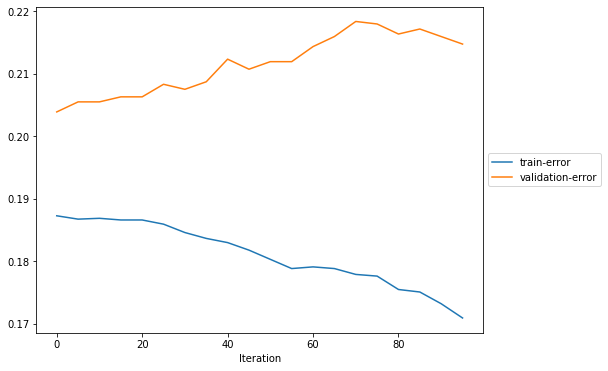

In [24]:
plot_collection(trial, "metrics")

#### Plot Feature Importance 

In [25]:
def plot_feature_importance(trial, importance_type="weight"):
    SUPPORTED_IMPORTANCE_TYPES = [
        "weight", "gain", "cover", "total_gain", "total_cover"]
    if importance_type not in SUPPORTED_IMPORTANCE_TYPES:
        raise ValueError(
            f"{importance_type} is not one of the supported importance types.")
    plot_collection(
        trial,
        "feature_importance",
        regex=f"feature_importance/{importance_type}/.*")

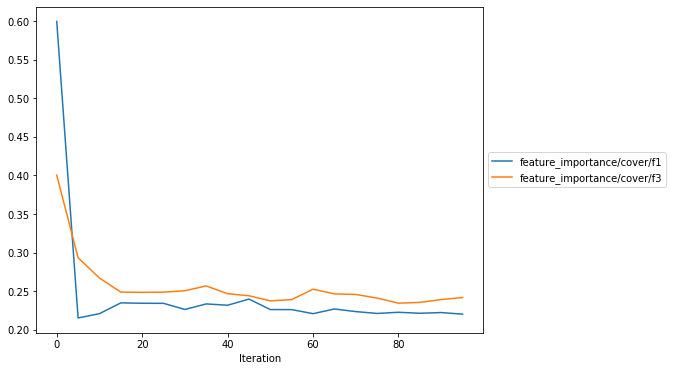

In [26]:
plot_feature_importance(trial, importance_type="cover")

#### Plot Average SHAP values 

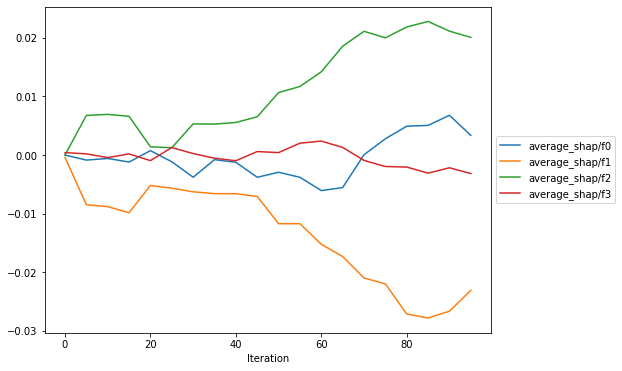

In [27]:
plot_collection(trial, "average_shap")

#### SHAP Visualizations 

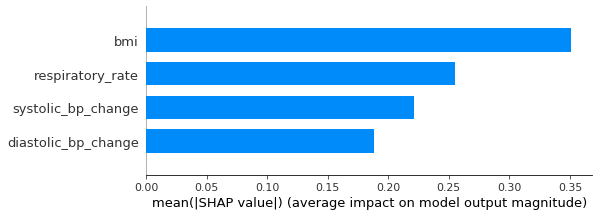

In [28]:
shap_values = trial.tensor("full_shap/f0").value(trial.last_complete_step)
shap_no_base = shap_values[:, :-1]
shap_base_value = shap_values[0, -1]
shap.summary_plot(shap_no_base, plot_type='bar', feature_names=feature_names)

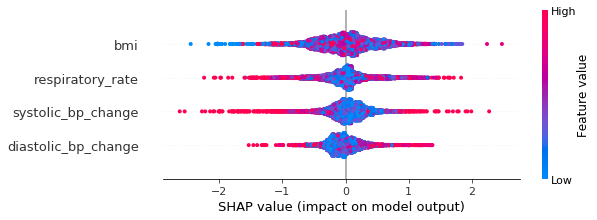

In [29]:
shap.summary_plot(shap_no_base, X_train)

In [30]:
shap.initjs()

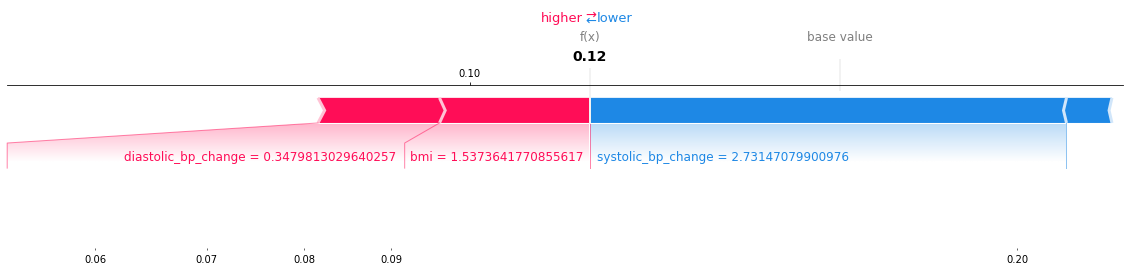

In [31]:
shap.force_plot(shap_base_value, shap_no_base[100, :],
                X_train.iloc[100, :], link="logit", matplotlib=True)

In [32]:
N_ROWS = shap_no_base.shape[0]
N_SAMPLES = min(100, N_ROWS)
sampled_indices = np.random.randint(N_ROWS, size=N_SAMPLES)

In [33]:
shap.force_plot(shap_base_value,
                shap_no_base[sampled_indices, :],
                X_train.iloc[sampled_indices, :],
                link='logit')